In [83]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from qdrant_client import QdrantClient
from concurrent.futures import ProcessPoolExecutor
from qdrant_client.http import models
import uuid as uuidpy
from skimage.feature import hog


COLOR_HIST_BINS = 32
LBP_POINTS = 24
LBP_RADIUS = 3
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)
HOG_ORIENTATIONS = 9

COLOR_FEATURE_SIZE = COLOR_HIST_BINS * 3  # 3 channels
LBP_FEATURE_SIZE = LBP_POINTS + 2
HOG_FEATURE_SIZE = ((64 // HOG_PIXELS_PER_CELL[0] - HOG_CELLS_PER_BLOCK[0] + 1) *
                    (64 // HOG_PIXELS_PER_CELL[1] - HOG_CELLS_PER_BLOCK[1] + 1) *
                    HOG_CELLS_PER_BLOCK[0] * HOG_CELLS_PER_BLOCK[1] * HOG_ORIENTATIONS)
TOTAL_FEATURE_SIZE = COLOR_FEATURE_SIZE + LBP_FEATURE_SIZE + HOG_FEATURE_SIZE


#### This cell defines a series of functions for image processing and feature extraction, including reading images from a folder, computing color histograms, texture, and edge features, resizing images, and computing feature vectors. It also includes functions to interact with Qdrant for storing and querying image embeddings.

In [ ]:

def store_single_embedding_in_qdrant(client, collection_name, image_path, feature_vector):
    """
    Stores a single embedding in Qdrant collection.

    Args:
        client (QdrantClient): The Qdrant client object.
        collection_name (str): The name of the collection to store the embedding in.
        image_path (str): The path of the image.
        feature_vector (numpy.ndarray): The feature vector of the image.

    Returns:
        None
    """
    # Create a payload with the image path
    payload = {"image_path": image_path}
    # Generate a unique ID for the point
    point_id = str(uuidpy.uuid4())
    # Create the point structure
    point = models.PointStruct(id=point_id, vector=feature_vector.tolist(), payload=payload)
    # Insert the point into the collection
    client.upsert(collection_name=collection_name, points=[point], wait=True)

def compute_color_histogram(image, bins=COLOR_HIST_BINS):
    """
    Compute the color histogram of an image.

    Parameters:
    image (numpy.ndarray): The input image.
    bins (int): The number of bins for the histogram. Default is COLOR_HIST_BINS.

    Returns:
    numpy.ndarray: The computed color histogram.

    """
    hist = [cv2.calcHist([image], [i], None, [bins], [0, 256]) for i in range(3)]
    hist = np.concatenate(hist).flatten()
    hist = hist / hist.sum()
    return hist

def compute_texture_features(image, radius=LBP_RADIUS, n_points=LBP_POINTS):
    """
    Compute texture features using Local Binary Patterns (LBP) on the given image.

    Parameters:
    - image: numpy.ndarray
        The input image.
    - radius: int, optional
        The radius of the circular neighborhood used for LBP. Default is LBP_RADIUS.
    - n_points: int, optional
        The number of points to sample on the circular neighborhood. Default is LBP_POINTS.

    Returns:
    - lbp_hist: numpy.ndarray
        The histogram of the Local Binary Patterns (LBP) computed on the image.
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist / lbp_hist.sum()
    return lbp_hist

def compute_edge_features(image):
    """
    Compute edge features of an image.

    Parameters:
    image (numpy.ndarray): The input image.

    Returns:
    numpy.ndarray: The computed edge histogram.

    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=5)
    edges = np.sqrt(sobelx ** 2 + sobely ** 2)
    edge_hist, _ = np.histogram(edges, bins=32, range=(0, 256))
    edge_hist = edge_hist / edge_hist.sum()
    return edge_hist

def resize_image(image, target_size=(128, 128)):
    """
    Resize the input image to the specified target size.
    
    Parameters:
    image (numpy.ndarray): The input image to be resized.
    target_size (tuple): The target size to resize the image to. Default is (128, 128).
    
    Returns:
    numpy.ndarray: The resized image.
    """
    resized_image = cv2.resize(image, target_size)
    return resized_image

def compute_feature_vector(image_path):
    """
    Compute the feature vector for an image.

    Parameters:
    image_path (str): The path to the image file.

    Returns:
    numpy.ndarray: The computed feature vector.
    """

    image = cv2.imread(image_path)
    print("image>>", image.shape)
    color_features = compute_color_histogram(image)
    texture_features = compute_texture_features(image)
    edge_features = compute_edge_features(image)
    weighted_color_features = color_features * 2
    feature_vector = np.concatenate([weighted_color_features, texture_features, edge_features])
    print("FV>>", len(feature_vector))

    return feature_vector


def create_qdrant_collection(client, collection_name, vector_dim):
    """
    Create a new collection in Qdrant.

    Args:
        client (QdrantClient): The Qdrant client object.
        collection_name (str): The name of the collection to be created.
        vector_dim (int): The dimension of the vectors in the collection.

    Returns:
        None
    """
    # Create a new collection if it does not exist
    client.create_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(size=vector_dim, distance=models.Distance.COSINE),
    )


def find_similar_images_in_qdrant(client, collection_name, input_image, top_k=2):
    """
    Find similar images in Qdrant collection based on an input image.

    Parameters:
    - client: Qdrant client object.
    - collection_name: Name of the collection in Qdrant.
    - input_image: Input image for which similar images need to be found.
    - top_k: Number of similar images to retrieve (default is 2).

    Returns:
    - List of dictionaries containing the URL and filename of similar images.
    """

    input_features = compute_feature_vector(input_image)

    # input_reduced_features = input_features
    search_result = client.search(
        collection_name=collection_name,
        query_vector=input_features.tolist(),
        query_filter=None,
        limit=top_k,
    )
    print("SR>>",search_result)
    similar_images = []
    for hit in search_result:
        print("hit>>",hit)
        similar_images.append({"url":hit.payload["url"], "filename":"/home/arunchandra/Downloads/images/"+hit.payload["filename"]})
    return similar_images



def process_image(image_path):
    """
    Wrapper function for processing a single image.
    
    Args:
        image_path (str): The path to the image file.
    
    Returns:
        tuple: A tuple containing the image_path and its feature_vector.
    """
    feature_vector = compute_feature_vector(image_path)
    return (image_path, feature_vector)

def process_and_store_images_parallel(folder_path, client, collection_name, vector_dim, max_workers=None):
    """
    Process and store images in parallel.

    Args:
        folder_path (str): The path to the folder containing the images.
        client: The client object for interacting with the Qdrant collection.
        collection_name (str): The name of the Qdrant collection.
        vector_dim (int): The dimension of the feature vectors.
        max_workers (int, optional): The maximum number of worker processes to use for parallel processing.
            If not specified, the default number of workers will be used.

    Returns:
        None
    """
    
    # Ensure the collection exists or create it if not
    create_qdrant_collection(client, collection_name, vector_dim)
    
    # Read image paths from the folder
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Process images in parallel to compute feature vectors
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        for image_path, feature_vector in executor.map(process_image, image_paths):
            store_single_embedding_in_qdrant(client, collection_name, image_path, feature_vector)


#### The main execution cell initializes the Qdrant client, specifies the folder path containing images, and processes these images in parallel to compute and store their feature vectors in a Qdrant collection. The vector dimension is set, and the collection name is defined.

In [48]:

# Main code
folder_path = '/home/arunchandra/Downloads/final'
client = QdrantClient(url="http://localhost:6333",api_key="API_KEY")
collection_name = "image_collection_final_color_edge"
process_and_store_images_parallel(folder_path, client, collection_name, 154)



image>> image>> (1440, 1080, 3)
image>> (1440, 1080, 3)
(1440, 1080, 3)image>> image>> 
image>>(2400, 1800, 3)image>> (2400, 1800, 3) (1440, 1080, 3)

image>> 
(2400, 1800, 3)(2400, 1800, 3)

FV>> 154
FV>> 154
image>> (2400, 1800, 3)
image>> (2400, 1800, 3)
FV>> 154
image>> (1440, 1080, 3)
FV>> 154
image>> (2400, 1800, 3)
FV>> 154
image>> (2400, 1800, 3)
FV>> 154
FV>> 154
FV>> 154
image>> (2400, 1800, 3)
image>> (2400, 1800, 3)
image>> (2400, 1800, 3)
FV>> 154
image>> (2400, 1800, 3)
FV>> 154
FV>> 154
image>> (2400, 1800, 3)
image>> (2400, 1800, 3)
FV>> 154
image>> (480, 360, 3)
FV>> 154
image>> (2400, 1800, 3)
FV>> 154
image>> (2400, 1800, 3)
FV>> 154
image>> (2400, 1800, 3)
FV>> 154
image>> (1440, 1080, 3)
FV>> 154
image>> (1440, 1080, 3)
FV>> 154
image>> (2400, 1800, 3)
FV>> 154
image>> (1440, 1080, 3)
FV>> 154
image>> (2400, 1800, 3)
FV>> 154
image>> (1440, 1080, 3)
FV>> 154
FV>> 154
image>> image>>(2400, 1800, 3)
 (2400, 1800, 3)
FV>> 154
image>> (2400, 1800, 3)
FV>> 154
FV>> 154i

#### This cell uses the Qdrant client to find similar images to a given input image by querying the Qdrant collection. The top k similar images are retrieved and displayed.

> Note: In this approach each feature has equal weights


In [103]:
input_image = '/home/arunchandra/Downloads/6.jpeg'
client = QdrantClient(url="http://localhost:6333",api_key="API_KEY")
collection_name = "jtp_final"
# Find similar images using Qdrant
similar_images = find_similar_images_in_qdrant(client, collection_name, input_image, top_k=20)
similar_images.append({"filename":input_image})
print("Similar images:", similar_images)



image>> (213, 237, 3)
FV>> 154
SR>> [ScoredPoint(id='0f6497b5-bad8-4481-90d5-ce52e791029e', version=17899, score=0.98652333, payload={'filename': '37494.jpg', 'url': 'http://assets.myntassets.com/v1/images/style/properties/eceffbcf057cbebd699c2bdc9cead8d8_images.jpg'}, vector=None, shard_key=None), ScoredPoint(id='aff3bc51-3751-4fd7-8511-7bb974b20c11', version=37708, score=0.98641115, payload={'filename': '59219.jpg', 'url': 'http://assets.myntassets.com/v1/images/style/properties/Titan-Him---Her-White-Watches_694d813fee5372d1b9a8d7041f8728de_images.jpg'}, vector=None, shard_key=None), ScoredPoint(id='a402c733-6c50-4045-ae0e-2380204cd362', version=34412, score=0.9861952, payload={'filename': '14733.jpg', 'url': 'http://assets.myntassets.com/v1/images/style/properties/630e7346de21c619979a5e7010b53c2d_images.jpg'}, vector=None, shard_key=None), ScoredPoint(id='3c706324-7d8e-4658-b00b-2a74aadad703', version=39144, score=0.9850165, payload={'filename': '56667.jpg', 'url': 'http://assets.my

#### Displaying Images Using Matplotlib

- The last image is the input image

img_idx>> /home/arunchandra/Downloads/images/37494.jpg
img_idx>> /home/arunchandra/Downloads/images/59219.jpg
img_idx>> /home/arunchandra/Downloads/images/14733.jpg
img_idx>> /home/arunchandra/Downloads/images/56667.jpg
img_idx>> /home/arunchandra/Downloads/images/36942.jpg
img_idx>> /home/arunchandra/Downloads/images/59240.jpg
img_idx>> /home/arunchandra/Downloads/images/33250.jpg
img_idx>> /home/arunchandra/Downloads/images/36941.jpg
img_idx>> /home/arunchandra/Downloads/images/32336.jpg
img_idx>> /home/arunchandra/Downloads/images/43151.jpg
img_idx>> /home/arunchandra/Downloads/images/33869.jpg
img_idx>> /home/arunchandra/Downloads/images/38031.jpg
img_idx>> /home/arunchandra/Downloads/images/29411.jpg
img_idx>> /home/arunchandra/Downloads/images/19296.jpg
img_idx>> /home/arunchandra/Downloads/images/41030.jpg
img_idx>> /home/arunchandra/Downloads/images/44993.jpg
img_idx>> /home/arunchandra/Downloads/images/45935.jpg
img_idx>> /home/arunchandra/Downloads/images/29772.jpg
img_idx>> 

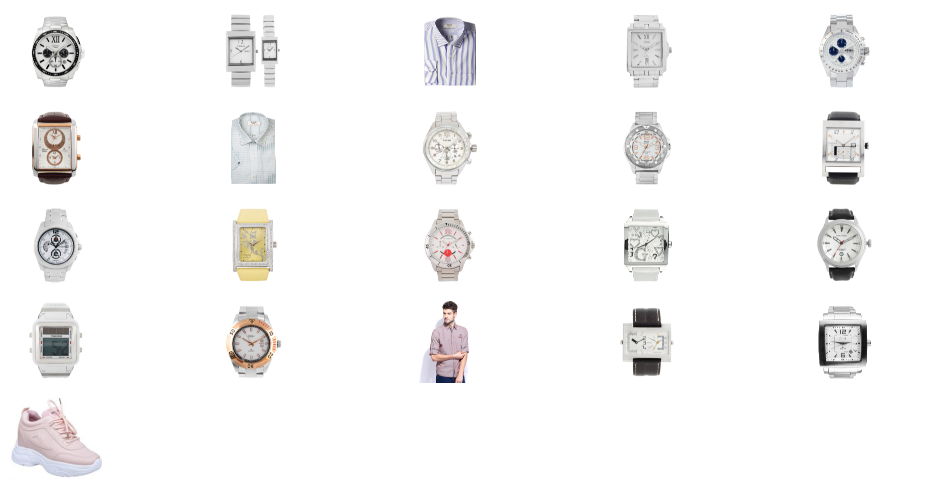

In [104]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# List of image file paths
image_paths = similar_images

# Define the dimensions of the image matrix
rows = 5
cols = 5

# Create a figure to display the images
fig, axes = plt.subplots(rows, cols, figsize=(10, 5))

# Iterate over the image paths and plot them in the matrix
for i in range(rows):
    for j in range(cols):
        ax = axes[j] if rows == 1 else axes[i, j]
        img_idx = i * cols + j
        if img_idx < len(image_paths):
            print("img_idx>>",image_paths[img_idx]['filename'])
            img = mpimg.imread(image_paths[img_idx]['filename'])
            ax.imshow(img)
        ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

#### This cell uses the Qdrant client to find similar images to a given input image by querying the Qdrant collection. The top k similar images are retrieved and displayed.

> Note: In this approach the color feature is weighted.
 Ratio is color:texture:edge = 2:1:1

In [66]:
input_image = '/media/arunchandra/local/Downloads/123.jpg'
client = QdrantClient(url="http://localhost:6333",api_key="API_KEY")
collection_name = "test_final_jtp_color_weighted"
# Find similar images using Qdrant
similar_images = find_similar_images_in_qdrant(client, collection_name, input_image, top_k=20)
similar_images.append(input_image)
print("Similar images:", similar_images)


image>> (2400, 1800, 3)
FV>> 154
SR>> [ScoredPoint(id='b29f1e5a-6e85-4b33-b2aa-b50151648731', version=0, score=0.98685586, payload={'image_path': '/home/arunchandra/Downloads/final/2103.jpg'}, vector=None, shard_key=None), ScoredPoint(id='a765d9aa-a0c4-44e2-9e7b-a3b50363c8e1', version=0, score=0.9808576, payload={'image_path': '/home/arunchandra/Downloads/final/2757.jpg'}, vector=None, shard_key=None), ScoredPoint(id='9d957b25-69b2-4b28-824c-4969e32cc382', version=0, score=0.9779484, payload={'image_path': '/home/arunchandra/Downloads/final/2760.jpg'}, vector=None, shard_key=None), ScoredPoint(id='dad2827d-3905-4a66-82f4-1187b6a421cc', version=0, score=0.97745794, payload={'image_path': '/home/arunchandra/Downloads/final/7176.jpg'}, vector=None, shard_key=None), ScoredPoint(id='7d59787d-4547-4e54-9189-4f41ab329c0a', version=0, score=0.97745067, payload={'image_path': '/home/arunchandra/Downloads/final/2099.jpg'}, vector=None, shard_key=None), ScoredPoint(id='85339950-b83c-42b3-b500-ea2

#### Displaying Images Using Matplotlib

- The last image is the input image

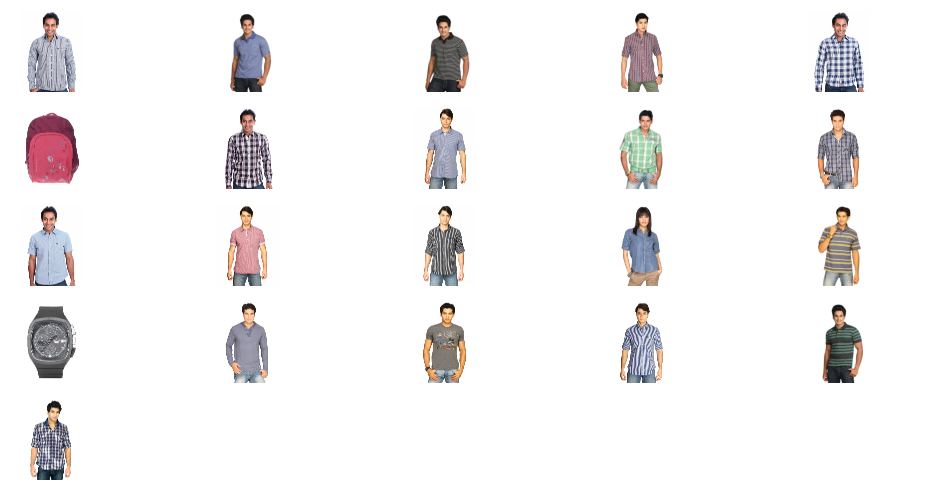

In [67]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# List of image file paths
image_paths = similar_images

# Define the dimensions of the image matrix
rows = 5
cols = 5

# Create a figure to display the images
fig, axes = plt.subplots(rows, cols, figsize=(10, 5))

# Iterate over the image paths and plot them in the matrix
for i in range(rows):
    for j in range(cols):
        ax = axes[j] if rows == 1 else axes[i, j]
        img_idx = i * cols + j
        if img_idx < len(image_paths):
            img = mpimg.imread(image_paths[img_idx])
            ax.imshow(img)
        ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

#### This cell uses the Qdrant client to find similar images to a given input image by querying the Qdrant collection. The top k similar images are retrieved and displayed.

> Note: In this approach the color and edge feature is weighted.
 Ratio is color:texture:edge = 2:1:2

In [68]:
input_image = '/media/arunchandra/local/Downloads/123.jpg'
client = QdrantClient(url="http://localhost:6333",api_key="API_KEY")
collection_name = "image_collection_final"
# Find similar images using Qdrant
similar_images = find_similar_images_in_qdrant(client, collection_name, input_image, top_k=20)
similar_images.append(input_image)
print("Similar images:", similar_images)


image>> (2400, 1800, 3)
FV>> 154
SR>> [ScoredPoint(id='a24ec001-7029-48f5-b431-237bb7a4c251', version=0, score=0.96354645, payload={'image_path': '/home/arunchandra/Downloads/final/2672.jpg'}, vector=None, shard_key=None), ScoredPoint(id='cd8b879c-3763-45a8-bd27-874d9a1b9a5b', version=0, score=0.9619398, payload={'image_path': '/home/arunchandra/Downloads/final/3302.jpg'}, vector=None, shard_key=None), ScoredPoint(id='cc618d55-9fb2-4227-885e-6906923a0214', version=0, score=0.9610821, payload={'image_path': '/home/arunchandra/Downloads/final/3229.jpg'}, vector=None, shard_key=None), ScoredPoint(id='a9a1a249-0fae-4b40-9ca8-f29aadb6e6c6', version=0, score=0.9590177, payload={'image_path': '/home/arunchandra/Downloads/final/2718.jpg'}, vector=None, shard_key=None), ScoredPoint(id='23e172cd-6695-4881-ad36-63908bb951a0', version=0, score=0.9579815, payload={'image_path': '/home/arunchandra/Downloads/final/2869.jpg'}, vector=None, shard_key=None), ScoredPoint(id='03eadf80-c452-4302-a010-b4303

#### Displaying Images Using Matplotlib

- The last image is the input image

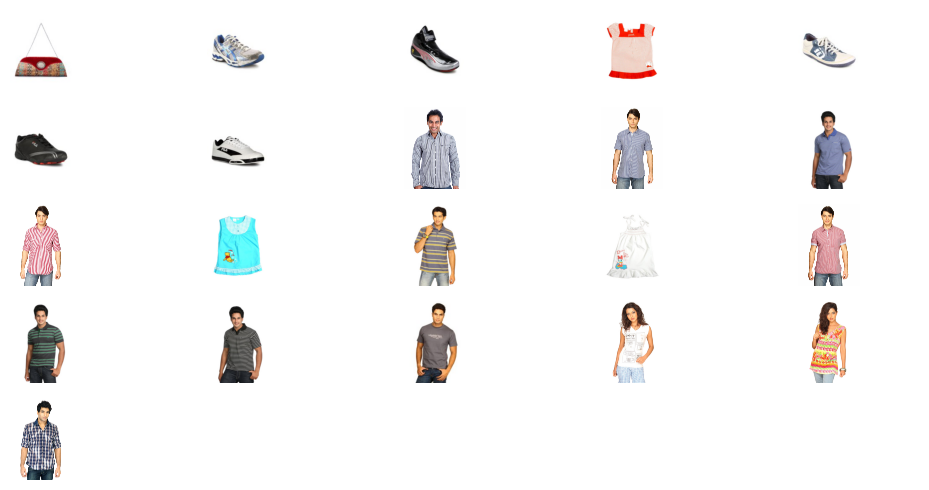

In [69]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# List of image file paths
image_paths = similar_images

# Define the dimensions of the image matrix
rows = 5
cols = 5

# Create a figure to display the images
fig, axes = plt.subplots(rows, cols, figsize=(10, 5))

# Iterate over the image paths and plot them in the matrix
for i in range(rows):
    for j in range(cols):
        ax = axes[j] if rows == 1 else axes[i, j]
        img_idx = i * cols + j
        if img_idx < len(image_paths):
            img = mpimg.imread(image_paths[img_idx])
            ax.imshow(img)
        ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()